In [1]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import AnchoredText
from numpy.polynomial.polynomial import polyfit
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, matthews_corrcoef
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
import pymongo
from pymongo import MongoClient
import itertools

In [2]:
# setting up connection to local DB and collections

local_client = MongoClient()
ufc_stats_db = local_client["ufc_stats_db"]
fights = ufc_stats_db["fights"]
fighters = ufc_stats_db["fighters"]
events = ufc_stats_db["events"]
event_fights = ufc_stats_db["event_fights"]
model_results = ufc_stats_db["model_results"]
model_picks = ufc_stats_db["model_picks"]

In [3]:
# importing from local mongo DB and converting to pandas DataFrame

# Ignore if importing from csv

model_results_cur = model_results.find({})
model_results_list_cur = list(model_results_cur)
model_results_df = pd.DataFrame(model_results_list_cur)
model_results_df = model_results_df.drop(columns="_id")
model_results_df

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v
0,Ciryl Gane,Francis Ngannou,blue,blue - KO/TKO,red,red - Decision,0.47,0.53,0.20,0.27,0.00,0.20,0.33,0.00,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,knn_no
1,Deiveson Figueiredo,Brandon Moreno,red,red - Decision,blue,blue - Decision,0.60,0.40,0.27,0.27,0.07,0.13,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,knn_no
2,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.67,0.33,0.47,0.20,0.00,0.27,0.07,0.00,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,knn_no
3,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.87,0.13,0.33,0.53,0.00,0.07,0.07,0.00,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,knn_no
4,Trevin Giles,Michael Morales,blue,blue - Decision,red,red - KO/TKO,0.47,0.53,0.27,0.13,0.07,0.33,0.13,0.07,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,knn_no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13200,Gilbert Urbina,Orion Cosce,red,red - Decision,blue,blue - KO/TKO,0.63,0.37,0.23,0.20,0.20,0.11,0.21,0.05,UFC Fight Night: Dern vs. Hill,Orion Cosce vs. Gilbert Urbina: UFC Fight Nigh...,mix_up
13201,Rodrigo Nascimento,Ilir Latifi,red,red - KO/TKO,blue,blue - Decision,0.63,0.37,0.25,0.27,0.10,0.13,0.15,0.09,UFC Fight Night: Dern vs. Hill,Ilir Latifi vs. Rodrigo Nascimento: UFC Fight ...,mix_up
13202,Nick Fiore,Chase Hooper,red,red - Submission,red,red - Decision,0.58,0.42,0.18,0.12,0.27,0.14,0.24,0.05,UFC Fight Night: Dern vs. Hill,Chase Hooper vs. Nick Fiore: UFC Fight Night: ...,mix_up
13203,Victoria Leonardo,Natalia Silva,red,red - Decision,red,red - KO/TKO,0.64,0.36,0.30,0.23,0.11,0.21,0.09,0.07,UFC Fight Night: Dern vs. Hill,Natalia Silva vs. Victoria Leonardo: UFC Fight...,mix_up


In [4]:
# exporting to csv in case needed

# model_results_df.to_csv("model_results.csv")

In [5]:
# importing from csv method

model_results_df = pd.read_csv("model_results.csv")
model_results_df = model_results_df.drop(columns="Unnamed: 0")
model_results_df

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v
0,Ciryl Gane,Francis Ngannou,blue,blue - KO/TKO,red,red - Decision,0.47,0.53,0.20,0.27,0.00,0.20,0.33,0.00,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,knn_no
1,Deiveson Figueiredo,Brandon Moreno,red,red - Decision,blue,blue - Decision,0.60,0.40,0.27,0.27,0.07,0.13,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,knn_no
2,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.67,0.33,0.47,0.20,0.00,0.27,0.07,0.00,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,knn_no
3,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.87,0.13,0.33,0.53,0.00,0.07,0.07,0.00,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,knn_no
4,Trevin Giles,Michael Morales,blue,blue - Decision,red,red - KO/TKO,0.47,0.53,0.27,0.13,0.07,0.33,0.13,0.07,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,knn_no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,Jake Collier,Martin Buday,red,red - Decision,red,red - Decision,0.60,0.40,0.34,0.19,0.07,0.17,0.20,0.03,UFC Fight Night: Song vs. Simon,Martin Buday vs. Jake Collier: UFC Fight Night...,mix_up
12536,Charles Johnson,Cody Durden,red,red - Decision,red,red - Decision,0.57,0.43,0.27,0.12,0.17,0.13,0.24,0.06,UFC Fight Night: Song vs. Simon,Cody Durden vs. Charles Johnson: UFC Fight Nig...,mix_up
12537,Irina Alekseeva,Stephanie Egger,red,red - Decision,blue,blue - Submission,0.78,0.22,0.33,0.12,0.33,0.14,0.05,0.03,UFC Fight Night: Song vs. Simon,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,mix_up
12538,Marcus McGhee,Journey Newson,red,red - Decision,blue,blue - Submission,0.55,0.45,0.32,0.17,0.06,0.27,0.14,0.04,UFC Fight Night: Song vs. Simon,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,mix_up


In [6]:
model_results_df["correct_winner"] = np.where(model_results_df.win_pred == model_results_df.actual_winner, 1, 0)
model_results_df

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v,correct_winner
0,Ciryl Gane,Francis Ngannou,blue,blue - KO/TKO,red,red - Decision,0.47,0.53,0.20,0.27,0.00,0.20,0.33,0.00,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,knn_no,0
1,Deiveson Figueiredo,Brandon Moreno,red,red - Decision,blue,blue - Decision,0.60,0.40,0.27,0.27,0.07,0.13,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,knn_no,0
2,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.67,0.33,0.47,0.20,0.00,0.27,0.07,0.00,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,knn_no,0
3,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.87,0.13,0.33,0.53,0.00,0.07,0.07,0.00,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,knn_no,0
4,Trevin Giles,Michael Morales,blue,blue - Decision,red,red - KO/TKO,0.47,0.53,0.27,0.13,0.07,0.33,0.13,0.07,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,knn_no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,Jake Collier,Martin Buday,red,red - Decision,red,red - Decision,0.60,0.40,0.34,0.19,0.07,0.17,0.20,0.03,UFC Fight Night: Song vs. Simon,Martin Buday vs. Jake Collier: UFC Fight Night...,mix_up,1
12536,Charles Johnson,Cody Durden,red,red - Decision,red,red - Decision,0.57,0.43,0.27,0.12,0.17,0.13,0.24,0.06,UFC Fight Night: Song vs. Simon,Cody Durden vs. Charles Johnson: UFC Fight Nig...,mix_up,1
12537,Irina Alekseeva,Stephanie Egger,red,red - Decision,blue,blue - Submission,0.78,0.22,0.33,0.12,0.33,0.14,0.05,0.03,UFC Fight Night: Song vs. Simon,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,mix_up,0
12538,Marcus McGhee,Journey Newson,red,red - Decision,blue,blue - Submission,0.55,0.45,0.32,0.17,0.06,0.27,0.14,0.04,UFC Fight Night: Song vs. Simon,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,mix_up,0


In [7]:
model_results_df = model_results_df[model_results_df["actual_winner"] != "Draw"]
model_results_df = model_results_df[model_results_df["actual_winner"] != "NC"]
model_results_df["total"] = len(model_results_df.index)
model_results_df

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v,correct_winner,total
0,Ciryl Gane,Francis Ngannou,blue,blue - KO/TKO,red,red - Decision,0.47,0.53,0.20,0.27,0.00,0.20,0.33,0.00,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,knn_no,0,12388
1,Deiveson Figueiredo,Brandon Moreno,red,red - Decision,blue,blue - Decision,0.60,0.40,0.27,0.27,0.07,0.13,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,knn_no,0,12388
2,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.67,0.33,0.47,0.20,0.00,0.27,0.07,0.00,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,knn_no,0,12388
3,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.87,0.13,0.33,0.53,0.00,0.07,0.07,0.00,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,knn_no,0,12388
4,Trevin Giles,Michael Morales,blue,blue - Decision,red,red - KO/TKO,0.47,0.53,0.27,0.13,0.07,0.33,0.13,0.07,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,knn_no,0,12388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,Jake Collier,Martin Buday,red,red - Decision,red,red - Decision,0.60,0.40,0.34,0.19,0.07,0.17,0.20,0.03,UFC Fight Night: Song vs. Simon,Martin Buday vs. Jake Collier: UFC Fight Night...,mix_up,1,12388
12536,Charles Johnson,Cody Durden,red,red - Decision,red,red - Decision,0.57,0.43,0.27,0.12,0.17,0.13,0.24,0.06,UFC Fight Night: Song vs. Simon,Cody Durden vs. Charles Johnson: UFC Fight Nig...,mix_up,1,12388
12537,Irina Alekseeva,Stephanie Egger,red,red - Decision,blue,blue - Submission,0.78,0.22,0.33,0.12,0.33,0.14,0.05,0.03,UFC Fight Night: Song vs. Simon,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,mix_up,0,12388
12538,Marcus McGhee,Journey Newson,red,red - Decision,blue,blue - Submission,0.55,0.45,0.32,0.17,0.06,0.27,0.14,0.04,UFC Fight Night: Song vs. Simon,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,mix_up,0,12388


In [8]:
winner_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_winner"].sum())
winner_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
winner_df["model_fights"] = model_results_df["total"][0] / winner_df["total_models"]
total_fights = winner_df["model_fights"][0].astype(int)
print(total_fights)
winner_df["incorrect_winner"] = (winner_df["model_fights"] - winner_df["correct_winner"]).astype(int)
winner_df["correct_%"] = round(((winner_df["correct_winner"] / winner_df["model_fights"]) * 100), 2)
winner_df = winner_df.drop(columns=["total_models", "model_fights"])
winner_df

652


,correct_winner,incorrect_winner,correct_%
model_v,,,
combined,410,242,62.88
knn_no,374,278,57.36
knn_rand,348,304,53.37
knn_up,360,292,55.21
log_no,378,274,57.98
log_rand,397,255,60.89
log_up,377,275,57.82
mix_no,380,272,58.28
mix_rand,388,264,59.51


In [9]:
model_results_df["correct_method"] = np.where(model_results_df.win_method == model_results_df.actual_method, 1, 0)
model_results_df

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v,correct_winner,total,correct_method
0,Ciryl Gane,Francis Ngannou,blue,blue - KO/TKO,red,red - Decision,0.47,0.53,0.20,0.27,0.00,0.20,0.33,0.00,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,knn_no,0,12388,0
1,Deiveson Figueiredo,Brandon Moreno,red,red - Decision,blue,blue - Decision,0.60,0.40,0.27,0.27,0.07,0.13,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,knn_no,0,12388,0
2,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.67,0.33,0.47,0.20,0.00,0.27,0.07,0.00,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,knn_no,0,12388,0
3,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.87,0.13,0.33,0.53,0.00,0.07,0.07,0.00,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,knn_no,0,12388,0
4,Trevin Giles,Michael Morales,blue,blue - Decision,red,red - KO/TKO,0.47,0.53,0.27,0.13,0.07,0.33,0.13,0.07,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,knn_no,0,12388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12535,Jake Collier,Martin Buday,red,red - Decision,red,red - Decision,0.60,0.40,0.34,0.19,0.07,0.17,0.20,0.03,UFC Fight Night: Song vs. Simon,Martin Buday vs. Jake Collier: UFC Fight Night...,mix_up,1,12388,1
12536,Charles Johnson,Cody Durden,red,red - Decision,red,red - Decision,0.57,0.43,0.27,0.12,0.17,0.13,0.24,0.06,UFC Fight Night: Song vs. Simon,Cody Durden vs. Charles Johnson: UFC Fight Nig...,mix_up,1,12388,1
12537,Irina Alekseeva,Stephanie Egger,red,red - Decision,blue,blue - Submission,0.78,0.22,0.33,0.12,0.33,0.14,0.05,0.03,UFC Fight Night: Song vs. Simon,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,mix_up,0,12388,0
12538,Marcus McGhee,Journey Newson,red,red - Decision,blue,blue - Submission,0.55,0.45,0.32,0.17,0.06,0.27,0.14,0.04,UFC Fight Night: Song vs. Simon,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,mix_up,0,12388,0


In [10]:
method_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_method"].sum())
method_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
method_df["model_fights"] = model_results_df["total"][0] / method_df["total_models"]
method_df["incorrect_method"] = (method_df["model_fights"] - method_df["correct_method"]).astype(int)
method_df["correct_%"] = round(((method_df["correct_method"] / method_df["model_fights"]) * 100), 2)
method_df = method_df.drop(columns=["total_models", "model_fights"])
method_df

,correct_method,incorrect_method,correct_%
model_v,,,
combined,217,435,33.28
knn_no,181,471,27.76
knn_rand,156,496,23.93
knn_up,178,474,27.30
log_no,199,453,30.52
log_rand,209,443,32.06
log_up,189,463,28.99
mix_no,193,459,29.60
mix_rand,193,459,29.60


In [11]:
model_results_df.groupby(["model_v"])["correct_method"].value_counts()

model_v   correct_method
combined  0                 435
          1                 217
knn_no    0                 471
          1                 181
knn_rand  0                 496
          1                 156
knn_up    0                 474
          1                 178
log_no    0                 453
          1                 199
log_rand  0                 443
          1                 209
log_up    0                 463
          1                 189
mix_no    0                 459
          1                 193
mix_rand  0                 459
          1                 193
mix_up    0                 459
          1                 193
mlp_no    0                 471
          1                 181
mlp_rand  0                 479
          1                 173
mlp_up    0                 476
          1                 176
nn_no     0                 447
          1                 205
nn_rand   0                 443
          1                 209
nn_up     0    

In [12]:
# selecting a model version for further analysis 

# model = model_results_df[model_results_df["model_v"] == "combined"]
model = model_results_df[model_results_df["model_v"] == "nn_rand"]
model

,blue_name,red_name,win_pred,win_method,actual_winner,actual_method,red_total_pct,blue_total_pct,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct,event,fight_id,model_v,correct_winner,total,correct_method
104,Ciryl Gane,Francis Ngannou,red,red - Decision,red,red - Decision,0.52,0.48,0.35,0.15,0.02,0.21,0.22,0.05,UFC 270: Ngannou vs. Gane,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,nn_rand,1,12388,1
105,Deiveson Figueiredo,Brandon Moreno,red,red - KO/TKO,blue,blue - Decision,0.66,0.34,0.30,0.31,0.05,0.08,0.13,0.13,UFC 270: Ngannou vs. Gane,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,nn_rand,0,12388,0
106,Said Nurmagomedov,Cody Stamann,red,red - Decision,blue,blue - Submission,0.55,0.45,0.35,0.18,0.02,0.27,0.15,0.03,UFC 270: Ngannou vs. Gane,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,nn_rand,0,12388,0
107,Victor Henry,Raoni Barcelos,red,red - KO/TKO,blue,blue - Decision,0.90,0.10,0.30,0.53,0.07,0.06,0.02,0.02,UFC 270: Ngannou vs. Gane,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,nn_rand,0,12388,0
108,Trevin Giles,Michael Morales,red,red - Decision,red,red - KO/TKO,0.60,0.40,0.26,0.21,0.12,0.23,0.07,0.11,UFC 270: Ngannou vs. Gane,Michael Morales vs. Trevin Giles: UFC 270: Nga...,nn_rand,1,12388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12491,Jake Collier,Martin Buday,blue,red - Decision,red,red - Decision,0.47,0.53,0.29,0.15,0.03,0.29,0.22,0.02,UFC Fight Night: Song vs. Simon,Martin Buday vs. Jake Collier: UFC Fight Night...,nn_rand,0,12388,1
12492,Charles Johnson,Cody Durden,red,red - Decision,red,red - Decision,0.60,0.40,0.41,0.06,0.14,0.25,0.13,0.02,UFC Fight Night: Song vs. Simon,Cody Durden vs. Charles Johnson: UFC Fight Nig...,nn_rand,1,12388,1
12493,Irina Alekseeva,Stephanie Egger,red,red - Decision,blue,blue - Submission,0.65,0.35,0.27,0.11,0.26,0.19,0.06,0.11,UFC Fight Night: Song vs. Simon,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,nn_rand,0,12388,0
12494,Marcus McGhee,Journey Newson,red,red - Decision,blue,blue - Submission,0.56,0.44,0.30,0.19,0.06,0.23,0.13,0.08,UFC Fight Night: Song vs. Simon,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,nn_rand,0,12388,0


In [13]:
# different bucket ranges 
bucket = 0.05
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 5

In [14]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_total_pct"] >= x]
    point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 1 observations
5% to 10%: 0% of 2 observations
10% to 15%: 28% of 7 observations
15% to 20%: 12% of 8 observations
20% to 25%: 27% of 26 observations
25% to 30%: 44% of 41 observations
30% to 35%: 43% of 54 observations
35% to 40%: 50% of 40 observations
40% to 45%: 45% of 56 observations
45% to 50%: 57% of 71 observations
50% to 55%: 64% of 75 observations
55% to 60%: 68% of 66 observations
60% to 65%: 61% of 51 observations
65% to 70%: 64% of 59 observations
70% to 75%: 78% of 37 observations
75% to 80%: 73% of 37 observations
80% to 85%: 86% of 22 observations
85% to 90%: 83% of 6 observations
90% to 95%: 50% of 4 observations
95% to 100%: 100% of 1 observations


In [15]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[7, 8, 26, 41, 54, 40, 56, 71, 75, 66, 51, 59, 37, 37, 22, 6]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[28, 12, 27, 44, 43, 50, 45, 57, 64, 68, 61, 64, 78, 73, 86, 83]


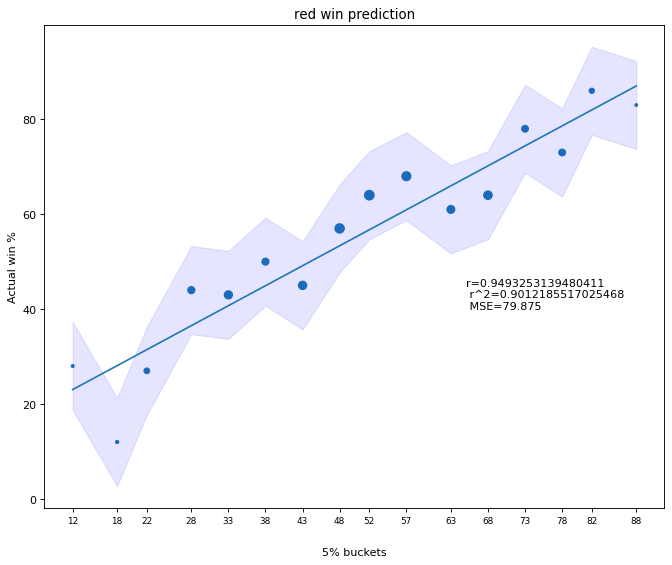

In [16]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(65, 40, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("red win prediction")
plt.show()

In [17]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_dec_pct"] >= x]
    point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 20 observations
5% to 10%: 12% of 69 observations
10% to 15%: 22% of 121 observations
15% to 20%: 24% of 70 observations
20% to 25%: 27% of 92 observations
25% to 30%: 34% of 86 observations
30% to 35%: 28% of 63 observations
35% to 40%: 31% of 39 observations
40% to 45%: 46% of 28 observations
45% to 50%: 44% of 16 observations
50% to 55%: 50% of 16 observations
55% to 60%: 27% of 11 observations
60% to 65%: 33% of 6 observations
65% to 70%: 40% of 5 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [18]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
print(observations)
print(half_points)
print(actual_win_pct)

[20, 69, 121, 70, 92, 86, 63, 39, 28, 16, 16, 11, 6, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[5, 12, 22, 24, 27, 34, 28, 31, 46, 44, 50, 27, 33, 40]


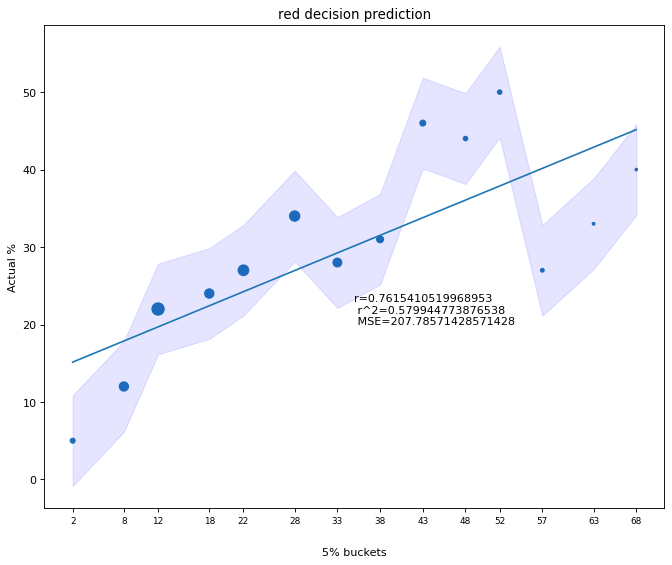

In [19]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 20, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red decision prediction")
plt.show()

In [20]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_ko_pct"] >= x]
    point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 3% of 60 observations
5% to 10%: 14% of 156 observations
10% to 15%: 16% of 149 observations
15% to 20%: 23% of 75 observations
20% to 25%: 22% of 63 observations
25% to 30%: 24% of 54 observations
30% to 35%: 17% of 30 observations
35% to 40%: 0% of 15 observations
40% to 45%: 55% of 11 observations
45% to 50%: 33% of 9 observations
50% to 55%: 20% of 5 observations
55% to 60%: 50% of 10 observations
60% to 65%: 50% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 100% of 2 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [21]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]

print(observations)
print(half_points)
print(actual_win_pct)

[60, 156, 149, 75, 63, 54, 30, 15, 11, 9, 5, 10]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[3, 14, 16, 23, 22, 24, 17, 0, 55, 33, 20, 50]


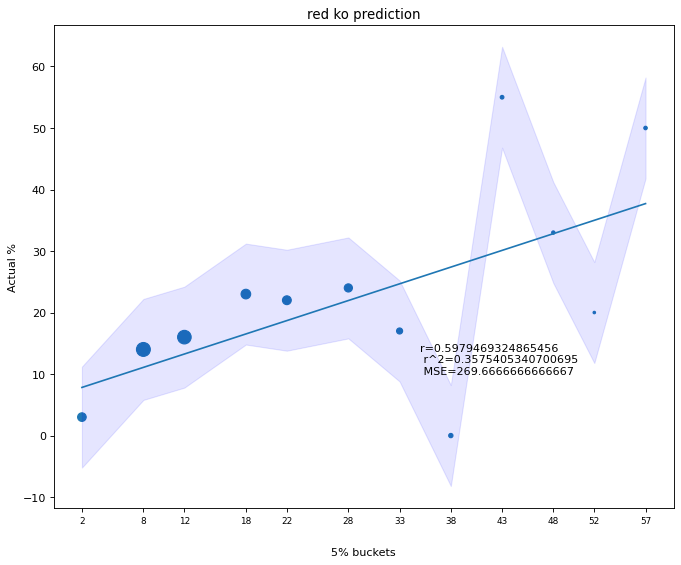

In [22]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red ko prediction")
plt.show()

In [23]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_sub_pct"] >= x]
    point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 202 observations
5% to 10%: 11% of 211 observations
10% to 15%: 14% of 123 observations
15% to 20%: 13% of 38 observations
20% to 25%: 24% of 25 observations
25% to 30%: 38% of 26 observations
30% to 35%: 20% of 10 observations
35% to 40%: 20% of 5 observations
40% to 45%: 25% of 4 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 33% of 3 observations
80% to 85%: 0% of 0 observations
85% to 90%: 100% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [24]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i] 

print(observations)
print(half_points)
print(actual_win_pct)

[202, 211, 123, 38, 25, 26, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[5, 11, 14, 13, 24, 38, 20, 20]


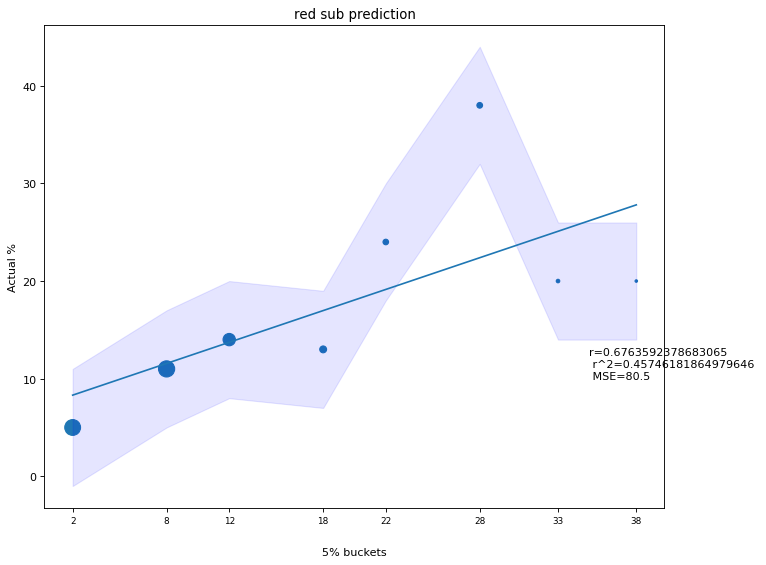

In [25]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red sub prediction")
plt.show()

In [26]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_total_pct"] >= x]
    point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 1 observations
5% to 10%: 33% of 3 observations
10% to 15%: 17% of 12 observations
15% to 20%: 14% of 14 observations
20% to 25%: 26% of 34 observations
25% to 30%: 22% of 37 observations
30% to 35%: 40% of 50 observations
35% to 40%: 40% of 40 observations
40% to 45%: 32% of 53 observations
45% to 50%: 35% of 75 observations
50% to 55%: 41% of 71 observations
55% to 60%: 54% of 69 observations
60% to 65%: 50% of 48 observations
65% to 70%: 57% of 59 observations
70% to 75%: 56% of 41 observations
75% to 80%: 68% of 28 observations
80% to 85%: 91% of 11 observations
85% to 90%: 71% of 7 observations
90% to 95%: 100% of 2 observations
95% to 100%: 100% of 1 observations


In [27]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[12, 14, 34, 37, 50, 40, 53, 75, 71, 69, 48, 59, 41, 28, 11, 7]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[17, 14, 26, 22, 40, 40, 32, 35, 41, 54, 50, 57, 56, 68, 91, 71]


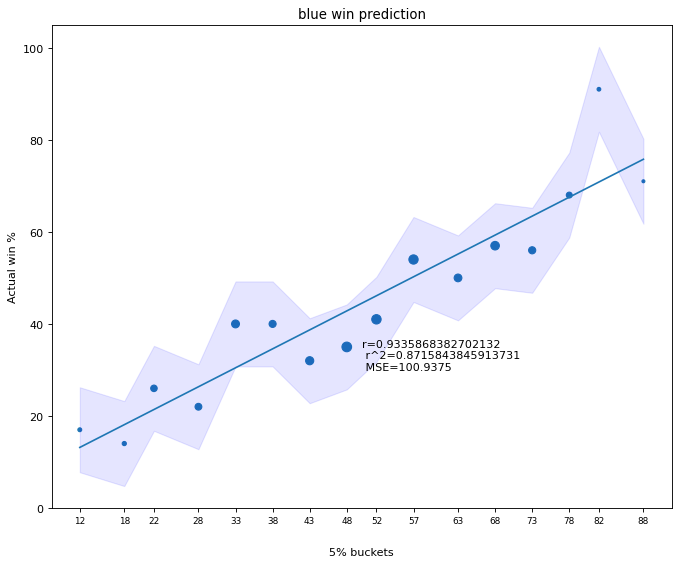

In [28]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(50, 30, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("blue win prediction")
plt.show()

In [29]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_dec_pct"] >= x]
    point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 12% of 16 observations
5% to 10%: 15% of 68 observations
10% to 15%: 12% of 119 observations
15% to 20%: 19% of 99 observations
20% to 25%: 19% of 102 observations
25% to 30%: 19% of 83 observations
30% to 35%: 16% of 55 observations
35% to 40%: 35% of 31 observations
40% to 45%: 31% of 32 observations
45% to 50%: 56% of 14 observations
50% to 55%: 62% of 8 observations
55% to 60%: 25% of 4 observations
60% to 65%: 0% of 1 observations
65% to 70%: 50% of 2 observations
70% to 75%: 0% of 0 observations
75% to 80%: 100% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [30]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[16, 68, 119, 99, 102, 83, 55, 31, 32, 14, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[12, 15, 12, 19, 19, 19, 16, 35, 31, 56, 62]


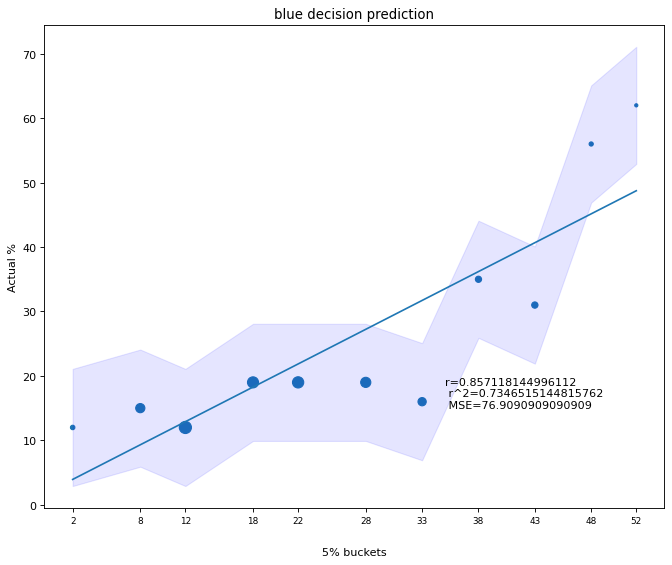

In [31]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 15, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue decision prediction")
plt.show()

In [32]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_ko_pct"] >= x]
    point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 64 observations
5% to 10%: 6% of 154 observations
10% to 15%: 6% of 145 observations
15% to 20%: 22% of 65 observations
20% to 25%: 21% of 66 observations
25% to 30%: 23% of 60 observations
30% to 35%: 17% of 29 observations
35% to 40%: 31% of 16 observations
40% to 45%: 43% of 21 observations
45% to 50%: 25% of 8 observations
50% to 55%: 44% of 9 observations
55% to 60%: 25% of 4 observations
60% to 65%: 100% of 2 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [33]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[64, 154, 145, 65, 66, 60, 29, 16, 21, 8, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[5, 6, 6, 22, 21, 23, 17, 31, 43, 25, 44]


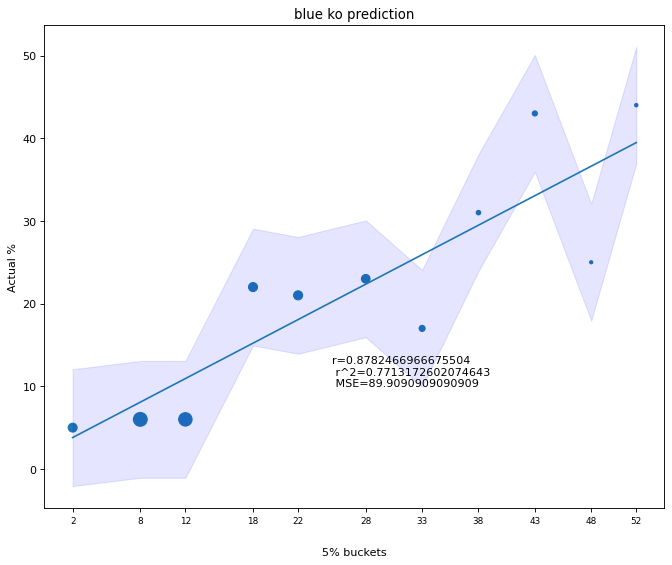

In [34]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(25, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue ko prediction")
plt.show()

In [35]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_sub_pct"] >= x]
    point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 6% of 220 observations
5% to 10%: 8% of 213 observations
10% to 15%: 11% of 99 observations
15% to 20%: 4% of 48 observations
20% to 25%: 15% of 33 observations
25% to 30%: 17% of 18 observations
30% to 35%: 25% of 8 observations
35% to 40%: 20% of 5 observations
40% to 45%: 0% of 2 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [36]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[220, 213, 99, 48, 33, 18, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[6, 8, 11, 4, 15, 17, 25, 20]


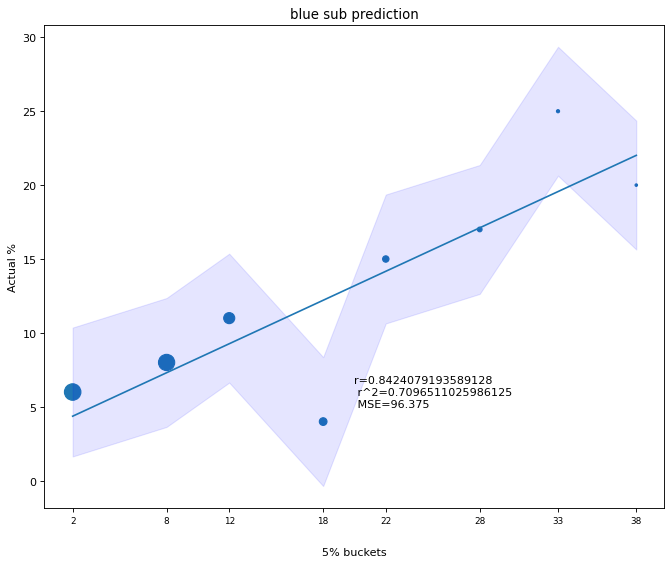

In [37]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(20, 5, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue sub prediction")
plt.show()

In [38]:
probas = model[["red_dec_pct", "red_ko_pct", "red_sub_pct", "blue_dec_pct", "blue_ko_pct", "blue_sub_pct"]]
probas

,red_dec_pct,red_ko_pct,red_sub_pct,blue_dec_pct,blue_ko_pct,blue_sub_pct
104,0.35,0.15,0.02,0.21,0.22,0.05
105,0.30,0.31,0.05,0.08,0.13,0.13
106,0.35,0.18,0.02,0.27,0.15,0.03
107,0.30,0.53,0.07,0.06,0.02,0.02
108,0.26,0.21,0.12,0.23,0.07,0.11
...,...,...,...,...,...,...
12491,0.29,0.15,0.03,0.29,0.22,0.02
12492,0.41,0.06,0.14,0.25,0.13,0.02
12493,0.27,0.11,0.26,0.19,0.06,0.11
12494,0.30,0.19,0.06,0.23,0.13,0.08


In [39]:
# probas = model[["red_total_pct", "blue_total_pct"]]
# probas

In [40]:
predicted_prob =  probas.values
predicted_prob

array([[0.35, 0.15, 0.02, 0.21, 0.22, 0.05],
       [0.3 , 0.31, 0.05, 0.08, 0.13, 0.13],
       [0.35, 0.18, 0.02, 0.27, 0.15, 0.03],
       ...,
       [0.27, 0.11, 0.26, 0.19, 0.06, 0.11],
       [0.3 , 0.19, 0.06, 0.23, 0.13, 0.08],
       [0.46, 0.08, 0.08, 0.28, 0.05, 0.05]])

In [41]:
# prediction_labels = combined["win_pred"]

In [42]:
prediction_labels = model["win_method"]

In [43]:
# actual_result = combined["actual_winner"]

In [44]:
actual_result = model["actual_method"]

In [45]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [46]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_rest")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.32
Auc: 0.47
Detail:
                   precision    recall  f1-score   support

  blue - Decision       0.29      0.39      0.33       130
    blue - KO/TKO       0.33      0.39      0.36        93
blue - Submission       0.18      0.09      0.12        56
   red - Decision       0.36      0.42      0.39       174
     red - KO/TKO       0.33      0.28      0.31       120
 red - Submission       0.30      0.13      0.18        79

         accuracy                           0.32       652
        macro avg       0.30      0.28      0.28       652
     weighted avg       0.31      0.32      0.31       652



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'blue - Decision'),
  Text(0, 1.5, 'blue - KO/TKO'),
  Text(0, 2.5, 'blue - Submission'),
  Text(0, 3.5, 'red - Decision'),
  Text(0, 4.5, 'red - KO/TKO'),
  Text(0, 5.5, 'red - Submission')])

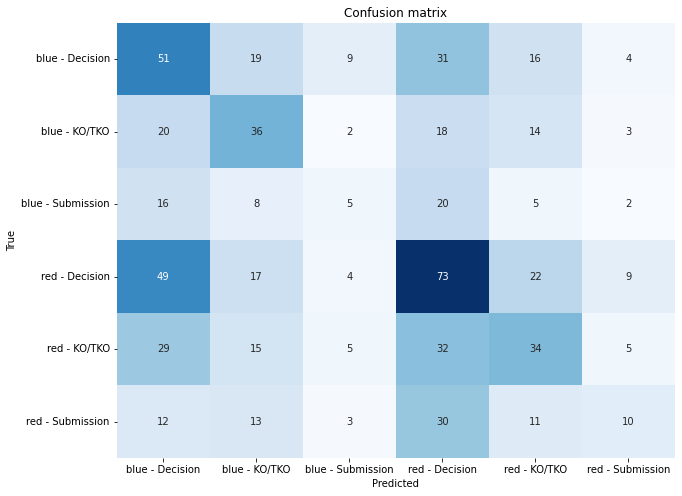

In [47]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

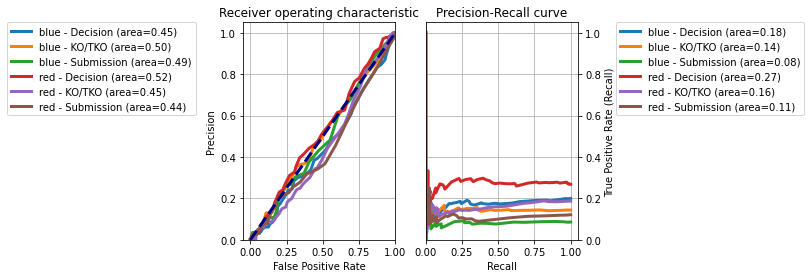

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [49]:
matthews_corrcoef(actual_result, prediction_labels)

0.15234783309846475

In [50]:
probas = model[["red_total_pct", "blue_total_pct"]]
probas

,red_total_pct,blue_total_pct
104,0.52,0.48
105,0.66,0.34
106,0.55,0.45
107,0.90,0.10
108,0.60,0.40
...,...,...
12491,0.47,0.53
12492,0.60,0.40
12493,0.65,0.35
12494,0.56,0.44


In [51]:
predicted_prob =  probas.values
predicted_prob

array([[0.52, 0.48],
       [0.66, 0.34],
       [0.55, 0.45],
       ...,
       [0.65, 0.35],
       [0.56, 0.44],
       [0.62, 0.38]])

In [52]:
prediction_labels = model["win_pred"]

In [53]:
actual_result = model["actual_winner"]

In [54]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [55]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_one")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.62
Auc: 0.34
Detail:
              precision    recall  f1-score   support

        blue       0.55      0.62      0.59       279
         red       0.69      0.62      0.65       373

    accuracy                           0.62       652
   macro avg       0.62      0.62      0.62       652
weighted avg       0.63      0.62      0.62       652



(array([0.5, 1.5]), [Text(0, 0.5, 'blue'), Text(0, 1.5, 'red')])

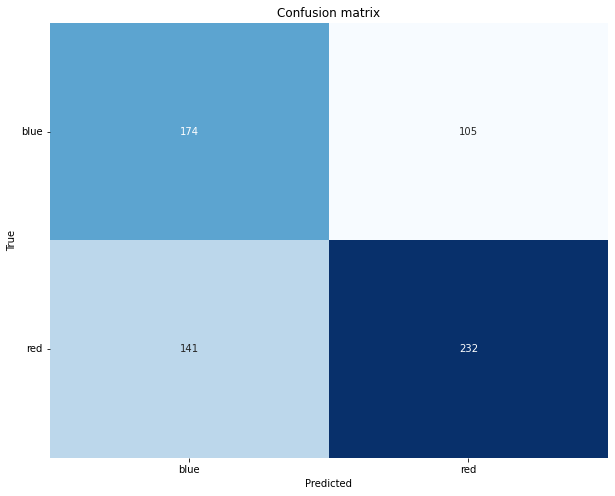

In [56]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

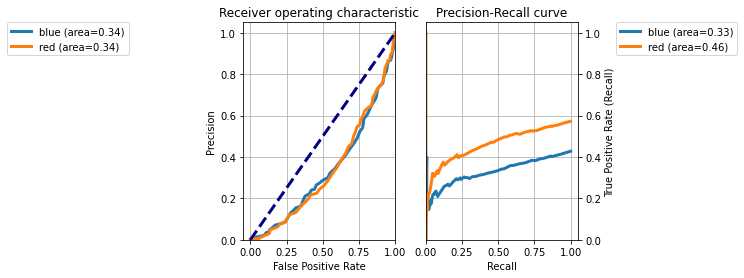

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [58]:
matthews_corrcoef(actual_result, prediction_labels)

0.24321204260506013

In [59]:
exact_pcts = list(np.random.randint(low=5, high=95, size=total_fights)/100)
# exact_pcts

In [60]:
exact_true = []
for n in exact_pcts:
#     print(n)
    test = list(np.random.randint(low=0,high=100, size=1) /100)
#     print(test[0])
    if test[0] <= n:
#         print("true")
        exact_true.append(1)
    else:
#         print("false")
        exact_true.append(0)

In [61]:
sum(exact_true) 

333

In [62]:
exact_dict = {"exact_pct" : exact_pcts,
             "true" : exact_true}
exact_df = pd.DataFrame(exact_dict)
exact_df

,exact_pct,true
0,0.74,1
1,0.70,1
2,0.13,0
3,0.91,1
4,0.85,1
...,...,...
647,0.71,1
648,0.52,1
649,0.42,0
650,0.14,0


In [63]:
# different bucket ranges 
bucket = 0.05
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 10

In [64]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = exact_df[exact_df["exact_pct"] >= x]
    point_to_point = point_up[point_up["exact_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["true"] == 1]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 0 observations
5% to 10%: 7% of 41 observations
10% to 15%: 8% of 39 observations
15% to 20%: 24% of 25 observations
20% to 25%: 28% of 35 observations
25% to 30%: 35% of 46 observations
30% to 35%: 30% of 30 observations
35% to 40%: 48% of 23 observations
40% to 45%: 38% of 34 observations
45% to 50%: 51% of 37 observations
50% to 55%: 51% of 49 observations
55% to 60%: 55% of 47 observations
60% to 65%: 70% of 33 observations
65% to 70%: 71% of 48 observations
70% to 75%: 71% of 31 observations
75% to 80%: 90% of 29 observations
80% to 85%: 87% of 39 observations
85% to 90%: 93% of 29 observations
90% to 95%: 92% of 39 observations
95% to 100%: 0% of 0 observations


In [65]:
empties = [i for i, j in enumerate(observations) if j < min_obs]    
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]

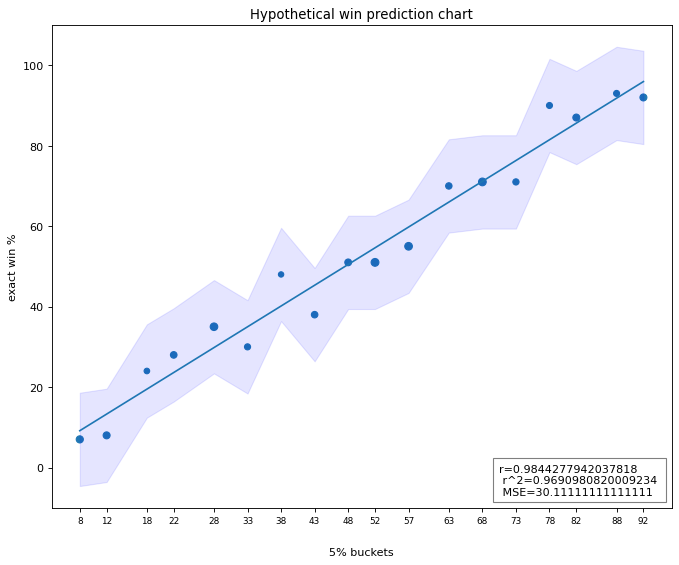

In [66]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)


mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
r_square = r_score*r_score

box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("exact win %")
plt.title("Hypothetical win prediction chart")
plt.show()

In [67]:
models = list(model_results_df["model_v"].unique())
models

['knn_no',
 'knn_rand',
 'knn_up',
 'log_no',
 'log_rand',
 'log_up',
 'rf_no',
 'rf_rand',
 'rf_up',
 'mlp_no',
 'mlp_rand',
 'mlp_up',
 'nn_no',
 'nn_rand',
 'nn_up',
 'mix_no',
 'mix_rand',
 'mix_up',
 'combined']

In [68]:
# # setting models to drop for mixing and matching manually
# models_to_drop = ["combined", "mlp_no", "mlp_rand", "mlp_up", "nn_no", "nn_rand", "nn_up", "rf_no", "rf_rand", "rf_up"]

In [69]:
# models = list(set(models) - set(models_to_drop))
# models

In [70]:
# clean_perm_list = [models]

In [71]:
# creating list of optional permutations of 2 or 3 models together
# defining n number of models to combine per permutation
n_combo = 1

raw_perms = list(itertools.permutations(models, r=n_combo))
raw_perm_list = list(raw_perms)
# print(raw_perm_list)
clean_perm_list = []
for i in raw_perm_list:
    i_list = list(i)
    
    in_list = False
    if clean_perm_list:
        for x in clean_perm_list:
#             print(x)
            if set(x) == set(i_list):
                in_list = True
#     print(in_list)
    if in_list == False:
        clean_perm_list.append(i_list)
        
#     print(i_list)
# raw_perms

In [72]:
# clean_perm_list

In [73]:
results_id_df = model_results_df[["fight_id", "actual_winner", "actual_method"]]
results_id_df

,fight_id,actual_winner,actual_method
0,Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...,red,red - Decision
1,Brandon Moreno vs. Deiveson Figueiredo: UFC 27...,blue,blue - Decision
2,Cody Stamann vs. Said Nurmagomedov: UFC 270: N...,blue,blue - Submission
3,Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...,blue,blue - Decision
4,Michael Morales vs. Trevin Giles: UFC 270: Nga...,red,red - KO/TKO
...,...,...,...
12535,Martin Buday vs. Jake Collier: UFC Fight Night...,red,red - Decision
12536,Cody Durden vs. Charles Johnson: UFC Fight Nig...,red,red - Decision
12537,Stephanie Egger vs. Irina Alekseeva: UFC Fight...,blue,blue - Submission
12538,Journey Newson vs. Marcus McGhee: UFC Fight Ni...,blue,blue - Submission


In [74]:
model_combo = []
r = []
r_squared = []
m_squared = []

bucket_str = int(bucket * 100)

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
#     print(perm_combo_df)

#     print(f"{perm_str} red win %")
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["red_total_pct"] >= x]
        point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
   
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} red win prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_red_win.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)   
        


In [75]:
# print(model_combo
# perm_combo_df

In [76]:
# print(len(clean_perm_list))
# print(len(model_combo))
# print(len(r))
# print(len(r_squared))
# print(len(m_squared))
red_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_win_df = pd.DataFrame(red_win_dict)
red_win_df = red_win_df.sort_values(by="mean_squared").reset_index()
red_win_df = red_win_df = red_win_df.drop(columns="index")
red_win_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_red_win.csv")
red_win_df

,model_combo,r_score,r_squared,mean_squared
0,5%_combined,0.916189,0.839403,36.444444
1,5%_mix_up,0.884055,0.781553,46.300000
2,5%_log_rand,0.966387,0.933904,56.000000
3,5%_nn_rand,0.946050,0.895010,73.923077
4,5%_mix_rand,0.888824,0.790009,80.818182
5,5%_mix_no,0.855271,0.731489,90.300000
6,5%_rf_rand,0.794712,0.631568,127.875000
7,5%_nn_no,0.909844,0.827817,141.142857
8,5%_log_no,0.775659,0.601647,150.153846
9,5%_knn_rand,0.617425,0.381213,163.727273


In [77]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} blue win %")
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["blue_total_pct"] >= x]
        point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)

        
#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)

    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} blue win prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_blue_win.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [78]:
blue_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_win_df = pd.DataFrame(blue_win_dict)
blue_win_df = blue_win_df.sort_values(by="mean_squared").reset_index()
blue_win_df = blue_win_df.drop(columns="index")
blue_win_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_blue_win.csv")
blue_win_df

,model_combo,r_score,r_squared,mean_squared
0,5%_combined,0.931096,0.866939,45.800000
1,5%_mix_up,0.877211,0.769500,55.200000
2,5%_mix_no,0.903628,0.816544,59.900000
3,5%_log_rand,0.969855,0.940618,76.307692
4,5%_nn_rand,0.927633,0.860502,88.400000
5,5%_mix_rand,0.850162,0.722775,104.454545
6,5%_nn_no,0.934731,0.873722,120.214286
7,5%_log_no,0.787652,0.620396,150.538462
8,5%_knn_rand,0.616743,0.380371,170.909091
9,5%_rf_rand,0.715755,0.512305,190.250000


In [79]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} red dec %")
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["red_dec_pct"] >= x]
        point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red decision prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_red_dec.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [80]:
red_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_dec_df = pd.DataFrame(red_dec_dict)
red_dec_df = red_dec_df.sort_values(by="mean_squared").reset_index()
red_dec_df = red_dec_df.drop(columns="index")
red_dec_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_red_dec.csv")
red_dec_df

,model_combo,r_score,r_squared,mean_squared
0,5%_combined,0.877444,0.769907,25.000000
1,5%_mix_up,0.772312,0.596466,43.285714
2,5%_mix_rand,0.859962,0.739534,45.222222
3,5%_log_rand,0.902881,0.815195,64.300000
4,5%_rf_up,0.366089,0.134021,66.000000
5,5%_knn_rand,0.707054,0.499925,86.000000
6,5%_log_up,0.616446,0.380005,94.500000
7,5%_nn_rand,0.817185,0.667791,102.083333
8,5%_log_no,0.648533,0.420595,126.800000
9,5%_rf_rand,0.050534,0.002554,129.166667


In [81]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} red ko %")
        
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["red_ko_pct"] >= x]
        point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red ko prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_red_ko.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [82]:
red_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_ko_df = pd.DataFrame(red_ko_dict)

red_ko_df = red_ko_df.sort_values(by="mean_squared").reset_index()
red_ko_df = red_ko_df.drop(columns="index")
red_ko_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_red_ko.csv")
red_ko_df

,model_combo,r_score,r_squared,mean_squared
0,5%_combined,0.969080,0.939116,20.571429
1,5%_log_rand,0.945429,0.893836,30.000000
2,5%_log_up,0.913427,0.834349,31.111111
3,5%_mix_no,0.946697,0.896234,33.000000
4,5%_mix_rand,0.812210,0.659686,44.285714
5,5%_rf_up,-0.055989,0.003135,58.000000
6,5%_rf_rand,0.515258,0.265491,60.500000
7,5%_knn_up,0.780051,0.608480,66.250000
8,5%_nn_no,0.876237,0.767791,78.000000
9,5%_mix_up,0.914144,0.835659,80.625000


In [83]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} red sub %")
        
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["red_sub_pct"] >= x]
        point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red sub prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_red_sub.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [84]:
red_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_sub_df = pd.DataFrame(red_sub_dict)
red_sub_df = red_sub_df.sort_values(by="mean_squared").reset_index()
red_sub_df = red_sub_df.drop(columns="index")
red_sub_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_red_sub.csv")
red_sub_df

,model_combo,r_score,r_squared,mean_squared
0,5%_mix_no,0.988533,0.977197,3.428571
1,5%_combined,0.969031,0.939022,13.666667
2,5%_log_rand,0.935588,0.875325,16.285714
3,5%_log_up,0.909510,0.827209,22.428571
4,5%_rf_rand,0.493172,0.243218,25.000000
5,5%_mix_rand,0.953460,0.909087,25.166667
6,5%_mix_up,0.951326,0.905021,30.500000
7,5%_knn_up,0.782215,0.611860,31.166667
8,5%_knn_rand,0.891035,0.793943,34.666667
9,5%_nn_rand,0.776918,0.603601,45.714286


In [85]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} blue dec %")
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["blue_dec_pct"] >= x]
        point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue decision prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_blue_dec.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [86]:
blue_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_dec_df = pd.DataFrame(blue_dec_dict)
blue_dec_df = blue_dec_df.sort_values(by="mean_squared").reset_index()
blue_dec_df = blue_dec_df.drop(columns="index")
blue_dec_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_blue_dec.csv")
blue_dec_df

,model_combo,r_score,r_squared,mean_squared
0,5%_rf_no,0.759514,0.576861,23.000000
1,5%_mix_rand,0.938079,0.879993,28.500000
2,5%_mix_no,0.827671,0.685039,35.571429
3,5%_rf_up,0.436976,0.190948,55.800000
4,5%_mix_up,0.772499,0.596755,56.000000
5,5%_nn_no,0.824083,0.679113,56.888889
6,5%_combined,0.814439,0.663310,61.000000
7,5%_log_rand,0.839754,0.705187,66.111111
8,5%_log_no,0.793336,0.629382,67.444444
9,5%_nn_rand,0.819503,0.671585,74.600000


In [87]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} blue ko %")
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["blue_ko_pct"] >= x]
        point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue ko prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_blue_ko.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [88]:
blue_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_ko_df = pd.DataFrame(blue_ko_dict)
blue_ko_df = blue_ko_df.sort_values(by="mean_squared").reset_index()
blue_ko_df = blue_ko_df.drop(columns="index")
blue_ko_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_blue_ko.csv")
blue_ko_df

,model_combo,r_score,r_squared,mean_squared
0,5%_nn_no,0.996479,0.992971,4.428571
1,5%_mix_up,0.976833,0.954202,7.857143
2,5%_rf_up,0.944267,0.891641,14.000000
3,5%_knn_no,0.943286,0.889788,17.166667
4,5%_mix_rand,0.965000,0.931225,17.875000
5,5%_combined,0.981374,0.963094,25.142857
6,5%_mix_no,0.789347,0.623068,29.333333
7,5%_nn_rand,0.900305,0.810549,44.000000
8,5%_rf_rand,0.506996,0.257045,49.000000
9,5%_rf_no,NaN,NaN,50.000000


In [89]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
#     print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]

    perm_str = f"{bucket_str}%_"
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
#     print(perm_str)
        
    model_combo.append(perm_str)
    
    perm_combo_df = perm_df.groupby(["fight_id"]).mean()
#     print(perm_combo_df)

    perm_combo_df = perm_combo_df.merge(results_id_df, left_on="fight_id", right_on="fight_id")
    perm_combo_df = perm_combo_df.drop_duplicates()
    
#     print(f"{perm_str} blue sub %")
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_combo_df[perm_combo_df["blue_sub_pct"] >= x]
        point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


#         print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

#     print(observations)
#     print(half_points)
#     print(actual_win_pct)
    
    plt.ioff()
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
#     plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    box_text = f"r={r_score} \n r^2={r_square} \n MSE={mse}"
    text_box = AnchoredText(box_text, frameon=True, loc=4, pad=0.5)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    plt.gca().add_artist(text_box)
    
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue sub prediction")
#     plt.show()
    plt.savefig(f"model_graphs/{perm_str}_blue_sub.png")
    plt.close()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [90]:
blue_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_sub_df = pd.DataFrame(blue_sub_dict)
blue_sub_df = blue_sub_df.sort_values(by="mean_squared").reset_index()
blue_sub_df = blue_sub_df.drop(columns="index")
blue_sub_df.to_csv(f"model_combo_csvs/{n_combo}_{bucket_str}_perms_blue_sub.csv")
blue_sub_df

,model_combo,r_score,r_squared,mean_squared
0,5%_mix_rand,0.918806,0.844205,13.166667
1,5%_mix_up,0.820408,0.673069,14.750000
2,5%_rf_up,0.889863,0.791856,15.600000
3,5%_knn_no,0.849589,0.721801,17.500000
4,5%_mlp_no,0.817346,0.668054,20.600000
5,5%_log_up,0.904876,0.818800,32.166667
6,5%_nn_no,0.826668,0.683380,32.600000
7,5%_combined,0.899725,0.809505,34.800000
8,5%_mix_no,0.921177,0.848567,36.750000
9,5%_log_rand,0.934528,0.873343,46.428571


In [91]:
concat_frames = [red_win_df, blue_win_df, red_dec_df, red_ko_df, red_sub_df, blue_dec_df, blue_ko_df, blue_sub_df]
concat_df = pd.concat(concat_frames)
concat_df

,model_combo,r_score,r_squared,mean_squared
0,5%_combined,0.916189,0.839403,36.444444
1,5%_mix_up,0.884055,0.781553,46.300000
2,5%_log_rand,0.966387,0.933904,56.000000
3,5%_nn_rand,0.946050,0.895010,73.923077
4,5%_mix_rand,0.888824,0.790009,80.818182
...,...,...,...,...
14,5%_nn_up,0.434583,0.188862,101.000000
15,5%_log_no,0.902982,0.815376,113.000000
16,5%_mlp_up,0.394318,0.155486,114.000000
17,5%_knn_up,0.405003,0.164027,142.571429


In [92]:
concat_mean = concat_df.groupby(["model_combo"]).mean().sort_values(by="mean_squared")
concat_mean.to_csv(f"model_combo_csvs/{n_combo}_mean_df.csv")
concat_mean.head(50)

,r_score,r_squared,mean_squared
model_combo,,,
5%_combined,0.919797,0.848787,32.803175
5%_mix_up,0.871099,0.764028,41.814732
5%_mix_rand,0.898313,0.809564,44.936125
5%_mix_no,0.837981,0.725060,53.941667
5%_log_rand,0.904442,0.823332,62.279136
5%_nn_no,0.846631,0.726798,84.616712
5%_nn_rand,0.818938,0.679993,86.406754
5%_rf_rand,0.376717,0.414784,95.898958
5%_log_no,0.772877,0.603804,109.866079


In [93]:
red_win_df = red_win_df.rename(columns={"r_squared": "red_win_r_squared", "mean_squared": "red_win_mse"})
blue_win_df = blue_win_df.rename(columns={"r_squared": "blue_win_r_squared", "mean_squared": "blue_win_mse"})
red_dec_df = red_dec_df.rename(columns={"r_squared": "red_dec_r_squared", "mean_squared": "red_dec_mse"})
red_ko_df = red_ko_df.rename(columns={"r_squared": "red_ko_r_squared", "mean_squared": "red_ko_mse"})
red_sub_df = red_sub_df.rename(columns={"r_squared": "red_sub_r_squared", "mean_squared": "red_sub_mse"})
blue_dec_df = blue_dec_df.rename(columns={"r_squared": "blue_dec_r_squared", "mean_squared": "blue_dec_mse"})
blue_ko_df = blue_ko_df.rename(columns={"r_squared": "blue_ko_r_squared", "mean_squared": "blue_ko_mse"})
blue_sub_df = blue_sub_df.rename(columns={"r_squared": "blue_sub_r_squared", "mean_squared": "blue_sub_mse"})

red_win_df = red_win_df.drop(columns="r_score")
blue_win_df = blue_win_df.drop(columns="r_score")
red_dec_df = red_dec_df.drop(columns="r_score")
red_ko_df = red_ko_df.drop(columns="r_score")
red_sub_df = red_sub_df.drop(columns="r_score")
blue_dec_df = blue_dec_df.drop(columns="r_score")
blue_ko_df = blue_ko_df.drop(columns="r_score")
blue_sub_df = blue_sub_df.drop(columns="r_score")

In [94]:
merge_frames = [red_win_df, blue_win_df, red_dec_df, red_ko_df, red_sub_df, blue_dec_df, blue_ko_df, blue_sub_df]

In [95]:
merged_df = reduce(lambda x,y: pd.merge(x,y, on='model_combo', how='outer'), merge_frames)
merged_df = merged_df.set_index("model_combo")
merged_df.to_csv(f"model_combo_csvs/{n_combo}_merged_df.csv")
merged_df

,red_win_r_squared,red_win_mse,blue_win_r_squared,blue_win_mse,red_dec_r_squared,red_dec_mse,red_ko_r_squared,red_ko_mse,red_sub_r_squared,red_sub_mse,blue_dec_r_squared,blue_dec_mse,blue_ko_r_squared,blue_ko_mse,blue_sub_r_squared,blue_sub_mse
model_combo,,,,,,,,,,,,,,,,
5%_combined,0.839403,36.444444,0.866939,45.800000,0.769907,25.000000,0.939116,20.571429,0.939022,13.666667,0.663310,61.000000,0.963094,25.142857,0.809505,34.800000
5%_mix_up,0.781553,46.300000,0.769500,55.200000,0.596466,43.285714,0.835659,80.625000,0.905021,30.500000,0.596755,56.000000,0.954202,7.857143,0.673069,14.750000
5%_log_rand,0.933904,56.000000,0.940618,76.307692,0.815195,64.300000,0.893836,30.000000,0.875325,16.285714,0.705187,66.111111,0.549244,142.800000,0.873343,46.428571
5%_nn_rand,0.895010,73.923077,0.860502,88.400000,0.667791,102.083333,0.438619,198.700000,0.603601,45.714286,0.671585,74.600000,0.810549,44.000000,0.492287,63.833333
5%_mix_rand,0.790009,80.818182,0.722775,104.454545,0.739534,45.222222,0.659686,44.285714,0.909087,25.166667,0.879993,28.500000,0.931225,17.875000,0.844205,13.166667
5%_mix_no,0.731489,90.300000,0.816544,59.900000,0.222337,143.250000,0.896234,33.000000,0.977197,3.428571,0.685039,35.571429,0.623068,29.333333,0.848567,36.750000
5%_rf_rand,0.631568,127.875000,0.512305,190.250000,0.002554,129.166667,0.265491,60.500000,0.243218,25.000000,0.755575,128.400000,0.257045,49.000000,0.650512,57.000000
5%_nn_no,0.827817,141.142857,0.873722,120.214286,0.545172,131.909091,0.767791,78.000000,0.444416,111.750000,0.679113,56.888889,0.992971,4.428571,0.683380,32.600000
5%_log_no,0.601647,150.153846,0.620396,150.538462,0.420595,126.800000,0.574063,158.545455,0.728623,51.875000,0.629382,67.444444,0.440349,60.571429,0.815376,113.000000


In [96]:
res = merged_df[~merged_df.gt(150).any(1)]
res = res[~res.lt(.6).any(1)]
res

,red_win_r_squared,red_win_mse,blue_win_r_squared,blue_win_mse,red_dec_r_squared,red_dec_mse,red_ko_r_squared,red_ko_mse,red_sub_r_squared,red_sub_mse,blue_dec_r_squared,blue_dec_mse,blue_ko_r_squared,blue_ko_mse,blue_sub_r_squared,blue_sub_mse
model_combo,,,,,,,,,,,,,,,,
5%_combined,0.839403,36.444444,0.866939,45.800000,0.769907,25.000000,0.939116,20.571429,0.939022,13.666667,0.663310,61.0,0.963094,25.142857,0.809505,34.800000
5%_mix_rand,0.790009,80.818182,0.722775,104.454545,0.739534,45.222222,0.659686,44.285714,0.909087,25.166667,0.879993,28.5,0.931225,17.875000,0.844205,13.166667
